# Manage Directories and Packages

In [ ]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/project/dataset/ssvep

chars  data_4s	raw  unigram_freq.csv  words


In [ ]:
import os
import sys

# Go to main working directory
#os.makedirs('/content/eegnet-charrnn', exist_ok=True)
#%cd /content/eegnet-charrnn

# Directory containing subject files
subject_rawdata_dir = '/content/drive/MyDrive/project/dataset/ssvep/raw' # All raw .mat files should be here. Make sure to upload them!
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_words_dir = "/content/drive/MyDrive/project/dataset/ssvep/words" # Where to store all word data

os.makedirs(subject_rawdata_dir, exist_ok=True)
os.makedirs(subject_chars_dir, exist_ok=True)
os.makedirs(subject_words_dir, exist_ok=True)

In [ ]:
#Install necessary packages
!pip install datasets
!pip install tensorflow==2.8.0
!pip install mne>=0.17.1 PyRiemann>=0.2.5 scikit-learn>=0.20.1 matplotlib>=2.2.3
!pip install torchinfo

# !git clone https://github.com/vlawhern/arl-eegmodels.git
# sys.path.append('/content/arl-eegmodels')

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.0


In [ ]:
# Import necessary libraries
import numpy as np
import string
import re
import json
import random
import gc
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from datasets import load_dataset
from scipy.io import loadmat
from scipy.signal import cheby1, filtfilt, resample

from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#load data and split

In [ ]:
import itertools

def get_session_splits():
    all_sessions = [0, 1, 2, 3, 4, 5]
    session_splits = []

    for train_sessions in itertools.combinations(all_sessions, 4):
        remaining = [s for s in all_sessions if s not in train_sessions]
        val_session = remaining[0]
        test1_session = remaining[1]
        session_splits.append({
            'train': list(train_sessions),
            'val': val_session,
            'test1': test1_session
        })
    return session_splits

def load_data_by_session_split(subject_list, root_dir, session_split):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test1, y_test1 = [], []

    for sid in subject_list:
        data = np.load(os.path.join(root_dir, f"S{sid}_chars.npy"))  # [26, 6, 64, 250]

        for c in range(26):
            for s in session_split['train']:
                X_train.append(data[c, s])
                y_train.append(c)
            X_val.append(data[c, session_split['val']])
            y_val.append(c)
            X_test1.append(data[c, session_split['test1']])
            y_test1.append(c)

    def preprocess(X, y):
        X = np.array(X)[..., np.newaxis]  # shape: [N, 64, 250, 1]
        y = np.array(y)
        return X, y

    return preprocess(X_train, y_train), preprocess(X_val, y_val), preprocess(X_test1, y_test1)


In [ ]:
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 44
shuffle = True

# EEGNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.5,
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet, self).__init__()
        if dropoutType == 'Dropout':
            DropoutClass = nn.Dropout
        elif dropoutType == 'SpatialDropout2D':
            DropoutClass = lambda p: nn.Dropout2d(p)
        else:
            raise ValueError("dropoutType must be 'Dropout' or 'SpatialDropout2D'")

        # Block 1
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, kernLength), padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(F1)

        self.depthwiseConv = nn.Conv2d(
            F1, F1 * D, kernel_size=(Chans, 1), groups=F1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.drop1 = DropoutClass(dropoutRate)

        # Block 2
        self.separable_depthwise = nn.Conv2d(
            F1 * D, F1 * D, kernel_size=(1, 16), groups=F1 * D, padding='same', bias=False
        )
        self.separable_pointwise = nn.Conv2d(
            F1 * D, F2, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(F2)
        self.activation2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.drop2 = DropoutClass(dropoutRate)

        # Final dense layer
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(F2 * ((Samples // 4) // 8), nb_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):  # x: (N, 1, Chans, Samples)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.depthwiseConv(x)
        x = self.bn2(x)
        x = self.activation1(x)
        x = self.avgpool1(x)
        x = self.drop1(x)

        x = self.separable_depthwise(x)
        x = self.separable_pointwise(x)
        x = self.bn3(x)
        x = self.activation2(x)
        x = self.avgpool2(x)
        x = self.drop2(x)

        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x


In [ ]:
from torchinfo import summary
# Creating an EEGNet model
#eegnet_model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')
eegnet_model = EEGNet(nb_classes=26, Chans=64, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout')
eegnet_model = EEGNet(nb_classes=26, Chans=64, Samples=250,
                      dropoutRate=0.2, kernLength=64,
                      F1=16, D=2, F2=32, dropoutType='Dropout').to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eegnet_model.parameters(), lr=1e-3)

summary(eegnet_model, input_size=(32,1, 64, 250))

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [32, 26]                  --
├─Conv2d: 1-1                            [32, 16, 64, 250]         1,024
├─BatchNorm2d: 1-2                       [32, 16, 64, 250]         32
├─Conv2d: 1-3                            [32, 32, 1, 250]          2,048
├─BatchNorm2d: 1-4                       [32, 32, 1, 250]          64
├─ELU: 1-5                               [32, 32, 1, 250]          --
├─AvgPool2d: 1-6                         [32, 32, 1, 62]           --
├─Dropout: 1-7                           [32, 32, 1, 62]           --
├─Conv2d: 1-8                            [32, 32, 1, 62]           512
├─Conv2d: 1-9                            [32, 32, 1, 62]           1,024
├─BatchNorm2d: 1-10                      [32, 32, 1, 62]           64
├─ELU: 1-11                              [32, 32, 1, 62]           --
├─AvgPool2d: 1-12                        [32, 32, 1, 7]            --
├─Dro

First, randomly select 33 subjects as seen subjects, and assign the remaining 2 subjects as unseen subjects. Then, perform k-fold cross-validation at the session level.

Each time, for a given subject:

- Use 4 out of 6 sessions for training  
- Use 1 session for validation  
- Use 1 session for Test1

There are  
$\binom{6}{4} = 15$  
such combinations per subject (i.e., up to 15-fold cross-validation with the same requirement).

| Dataset | Subjects Used         | Sessions Used     |
|---------|------------------------|--------------------|
| Train   | 33 seen subjects       | [0, 1, 2, 3]       |
| Val     | Same 33 seen subjects  | [4]               |
| Test1   | Same 33 seen subjects  | [5]               |
| Test2   | 2 unseen subjects      | [0, 1, 2, 3, 4, 5] |


In [ ]:
def make_loader(X, y, batch_size=32, shuffle=True):
        X_tensor = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, 1, 64, 250)
        y_tensor = torch.tensor(np.array(y), dtype=torch.long)
        return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)


In [ ]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    total_loss, correct = 0.0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)


In [ ]:
def eval_loader(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            pred = output.argmax(1)
            correct += (pred == y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
def compute_loss_on_loader(model, criterion, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

session_splits = get_session_splits()

all_subjects = list(range(1, 36))
random.seed(42)
seen_subjects = random.sample(all_subjects, 33)
unseen_subjects = [s for s in all_subjects if s not in seen_subjects]


val_accs, test1_accs, test2_accs = [], [], []
all_histories = []

for fold, sess_split in enumerate(session_splits):
    print(f"\n===== Fold {fold+1} / {len(session_splits)} =====")

    (X_train, y_train), (X_val, y_val), (X_test1, y_test1) = load_data_by_session_split(
        seen_subjects, subject_chars_dir, sess_split)

    X_test2, y_test2 = [], []
    for sid in unseen_subjects:
        data = np.load(os.path.join(subject_chars_dir, f"S{sid}_chars.npy"))
        for c in range(26):
            for s in range(6):
                X_test2.append(data[c, s])
                y_test2.append(c)
    X_test2 = np.array(X_test2)[..., np.newaxis]

    train_loader = make_loader(X_train, y_train)
    val_loader = make_loader(X_val, y_val, shuffle=False)
    test1_loader = make_loader(X_test1, y_test1, shuffle=False)
    test2_loader = make_loader(X_test2, y_test2, shuffle=False)

    model = EEGNet(nb_classes=26, Chans=64, Samples=250, dropoutRate=0.2,
                   kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout').to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses, train_accuracies, val_accuracies, val_losses = [], [], [], []

    for epoch in range(50):
        model.train()
        correct = 0
        total_loss = 0.0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = correct / total
        avg_val_acc = eval_loader(model, val_loader, device)
        avg_val_loss = compute_loss_on_loader(model, criterion, val_loader, device)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)
        val_losses.append(avg_val_loss)

    all_histories.append({
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    })

    acc_val = val_accuracies[-1]
    acc_test1 = eval_loader(model, test1_loader, device)
    acc_test2 = eval_loader(model, test2_loader, device)

    print(f"[Fold {fold+1}] Val Acc: {acc_val:.4f}, Test1 Acc: {acc_test1:.4f}, Test2 Acc: {acc_test2:.4f}")
    val_accs.append(acc_val)
    test1_accs.append(acc_test1)
    test2_accs.append(acc_test2)

    torch.save(model.state_dict(), f"model_fold{fold+1}.pth")

print("\n===== Summary =====")
print(f"Avg Val Acc   : {np.mean(val_accs):.4f}")
print(f"Avg Test1 Acc : {np.mean(test1_accs):.4f}")
print(f"Avg Test2 Acc : {np.mean(test2_accs):.4f}")


===== Fold 1 / 15 =====
[Fold 1] Val Acc: 0.8800, Test1 Acc: 0.8823, Test2 Acc: 0.8622

===== Fold 2 / 15 =====
[Fold 2] Val Acc: 0.8508, Test1 Acc: 0.8718, Test2 Acc: 0.7981

===== Fold 3 / 15 =====
[Fold 3] Val Acc: 0.8683, Test1 Acc: 0.8683, Test2 Acc: 0.8269

===== Fold 4 / 15 =====
[Fold 4] Val Acc: 0.8695, Test1 Acc: 0.8706, Test2 Acc: 0.7981

===== Fold 5 / 15 =====
[Fold 5] Val Acc: 0.8904, Test1 Acc: 0.8765, Test2 Acc: 0.8237

===== Fold 6 / 15 =====
[Fold 6] Val Acc: 0.8473, Test1 Acc: 0.8322, Test2 Acc: 0.8013

===== Fold 7 / 15 =====
[Fold 7] Val Acc: 0.8135, Test1 Acc: 0.8252, Test2 Acc: 0.7596

===== Fold 8 / 15 =====
[Fold 8] Val Acc: 0.8893, Test1 Acc: 0.8718, Test2 Acc: 0.8237

===== Fold 9 / 15 =====
[Fold 9] Val Acc: 0.8998, Test1 Acc: 0.8765, Test2 Acc: 0.8301

===== Fold 10 / 15 =====
[Fold 10] Val Acc: 0.8590, Test1 Acc: 0.8566, Test2 Acc: 0.8173

===== Fold 11 / 15 =====
[Fold 11] Val Acc: 0.8974, Test1 Acc: 0.9009, Test2 Acc: 0.8045

===== Fold 12 / 15 =====
[F

In [ ]:
# Save current model
torch.save(model.state_dict(), "first_try_char_no_aug.pth")

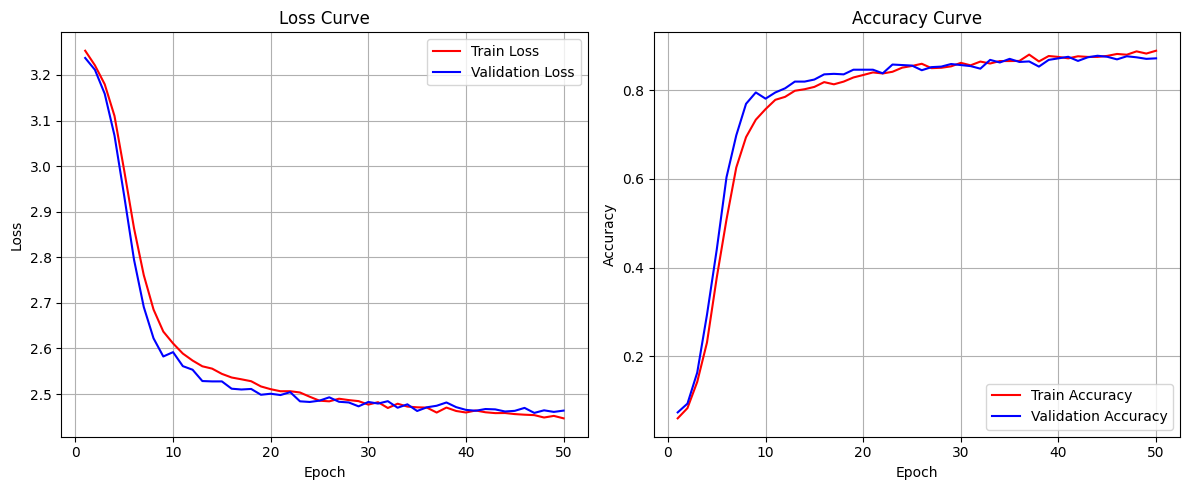

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Train Loss')
plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

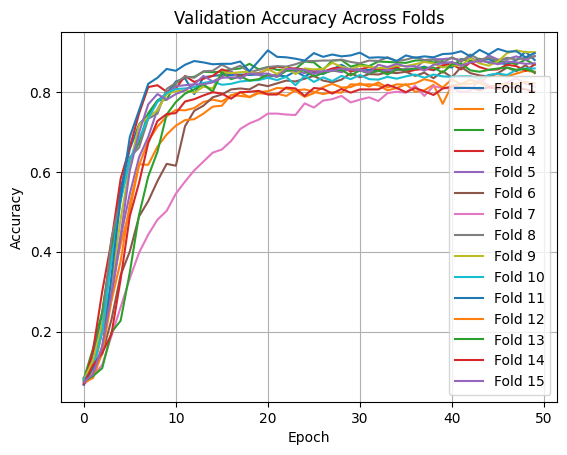

In [ ]:
for i, h in enumerate(all_histories):
    plt.plot(h['val_accuracy'], label=f'Fold {i+1}')
plt.legend()
plt.title("Validation Accuracy Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()